# Demo of a distributed scheduler

Gotta import the stuff we want to use.

In [1]:
import dask
from dask.distributed import Client, LocalCluster

## Creating a cluster

Start by creating a `LocalCluster` with some parameters. We can use the `print` method in `LocalCluster` to see some information.

In [2]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)
print(cluster)  # call print due to ipywidgets bug

LocalCluster('tcp://127.0.0.1:39111', workers=4, nthreads=4)


The first address is the address to the scheduler, which is useful if we need to directly interact with the scheduler from other computers/nodes (usually, we don't).

We can examine some information on both the scheduler and the workers that are associated with this cluster.

In [ ]:
cluster.scheduler

We haven't talked about the "Nanny" process -- this is a small process that spawns, monitors and kills workers when their work is done. She's a fierce nanny, that one.

## The dashboard

The really, really cool thing about setting up clusters like this is that they come with a neat dashboard. *If*, that is, you have `bokeh` installed. We can access it using the handy method associated with the cluster.

In [ ]:
cluster.dashboard_link

The main cool tabs are the Status and Graph tabs. **Note**: if for some reason your Graph tab is not showing your task graph, it may have to do with changing the settings of your cluster. Try restarting the kernel and reloading the dashboard, and it should work.

## Create a client

We've created the cluster, and the next step is to interface a client with the cluster. Once we do this, any subsequent calls of `dask.compute` will launch on our cluster.

In [3]:
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:39111 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 5.10 GB


As you can see, when printed in a Jupyter cell, the client prints cool information about the scheduler, Dashboard and cluster.

## Create task graph

We need to create our task graph before we can launch it. Let's reuse our `myreduce` task graph.

In [4]:
def add(x, y):
    n = 2e7
    while n>0:
        n -= 1
    return x+y

In [ ]:
# %load 2_rink.py
def myreduce(func, inplist):
    """A parallelizable reduce function"""
    if len(inplist) == 1:  # if one item, return it
        return inplist[0]
    elif len(inplist) == 2:  # if two items, call the function
        return func(*inplist)
    else:
        res_first = myreduce(func, inplist[:len(inplist) //2])  # recur reduce on first half
        res_second = myreduce(func, inplist[len(inplist) //2:])  # recur reduce on second half
        return func(res_first, res_second)

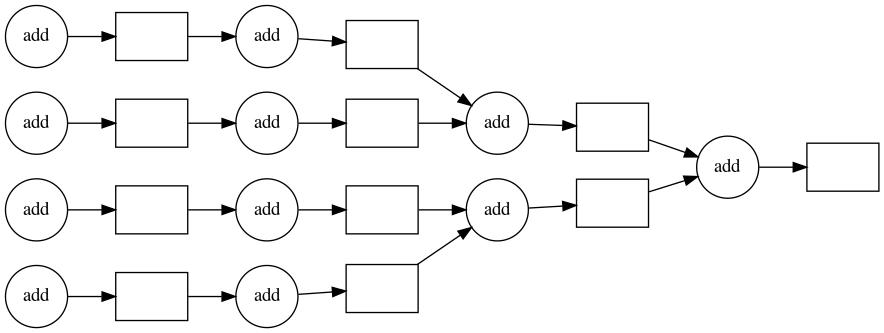

In [6]:
z = myreduce(dask.delayed(add), range(12))
z.visualize(rankdir='LR')

## Launch the task graph onto the scheduler

Since we've connected to a cluster through a client, dask knows to deploy this task graph on the cluster.

In [7]:
z.compute()

66

## Close the client and cluster

Dask sometimes has issues shutting down the cluster's dashboard, so I would recommend using both the client and the cluster as context managers in real scripts. But since we want the interactive set-up here, we will manually close and then delete the objects. And hopefully this kills the dashboard properly. If not, restart the kernel.

In [9]:
client.close()
del client
cluster.close()
del cluster

# Everything in a single cell

For the exercise, it'll be easier to have everything in a single cell with context managers. So, here you go. (Note that this assumes z has already been defined.) I'm so nice to you guys. <3

In [ ]:
with LocalCluster(n_workers=1, threads_per_worker=4) as cluster:
    with Client(cluster) as client:
        z.compute()